In [1]:
import sys
import os
import types
import warnings
import glob
import regex as re
import netCDF4 as nc
import rasterio
import numpy as np
import xarray as xr
import hvplot.xarray
import holoviews as hv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf
import ipywidgets as widgets
import matplotlib.ticker as mticker
import chardet
import pyperclip
from geopandas import GeoDataFrame
from shapely.geometry import Point
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from rasterio.transform import from_origin
from rasterstats import zonal_stats
from shapely.geometry import LineString
from matplotlib.path import Path
from matplotlib.colors import Normalize
from netCDF4 import Dataset
from pyproj import CRS
from IPython.display import display
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from windbreaks_helpers import *

In [2]:
warnings.filterwarnings('ignore')

## Set data source variables

In [3]:
# Path to the directory
directory = 'Data'

# Check if the directory exists
if os.path.isdir(directory):
    src_dir = directory
else:
    src_dir = None

print(src_dir)

Data


# Preprocess Crop Loss Data

In [4]:
years = [str(year) for year in range(2014, 2020)]
states = ['KS', 'NE']
crop_data = combine_files(src_dir+'/_alldata', years, states)

In [ ]:
# crop_data = pd.read_csv(os.path.join(src_dir,'crop_loss_COL/CleanCropData.csv'))
crop_data.head()

<Axes: xlabel='Year of Loss', ylabel='Indemnity Amount'>

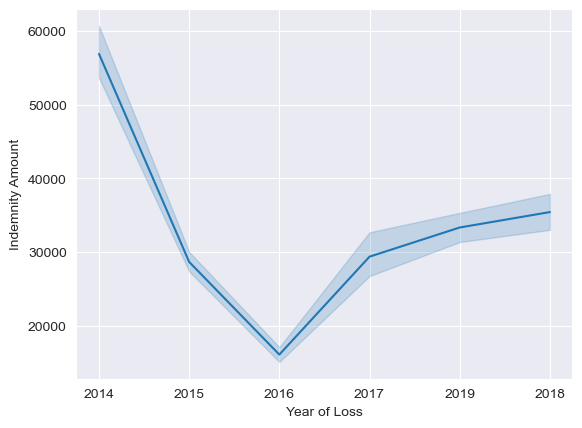

In [12]:
sns.lineplot(x=crop_data['Year of Loss'], y=crop_data['Indemnity Amount'])

In [ ]:
%whos


In [13]:
# crop_data = remove_outliers(crop_data, 'Year of Loss')
# sns.distplot(crop_data['Year of Loss'], bins=10, kde_kws={'shade': True})

In [14]:
# get column names with their index
print('\n', 'crop_data columns:', '\n')
output_string = ''

for i, col_name in enumerate(crop_data.columns):
    dtype = crop_data[col_name].dtype
    output_string += f'Index: {i}, Column Name: {col_name}, Data Type: {dtype}\n'

pyperclip.copy('crop_data:\n' + output_string)
print(output_string)


 crop_data columns: 

Index: 0, Column Name: Commodity Year Identifier, Data Type: int64
Index: 1, Column Name: State Code, Data Type: int64
Index: 2, Column Name: State Abbreviation, Data Type: object
Index: 3, Column Name: County Code, Data Type: int64
Index: 4, Column Name: County Name, Data Type: object
Index: 5, Column Name: Commodity Code, Data Type: int64
Index: 6, Column Name: Commodity Name, Data Type: object
Index: 7, Column Name: Insurance Plan Code, Data Type: int64
Index: 8, Column Name: Insurance Plan Name Abbreviation, Data Type: object
Index: 9, Column Name: Coverage Category, Data Type: object
Index: 10, Column Name: Stage Code, Data Type: object
Index: 11, Column Name: Cause of Loss Code, Data Type: object
Index: 12, Column Name: Cause of Loss Description, Data Type: object
Index: 13, Column Name: Month of Loss, Data Type: int64
Index: 14, Column Name: Month of Loss Name, Data Type: object
Index: 15, Column Name: Year of Loss, Data Type: object
Index: 16, Column Name

In [15]:
columns_to_drop = crop_data.columns[[0, 7, 8, 9, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]]
crop_data = crop_data.drop(columns=columns_to_drop)

In [16]:
# get column names with their index
print('\n', 'crop_data columns:', '\n')
output_string = ''

for i, col_name in enumerate(crop_data.columns):
    dtype = crop_data[col_name].dtype
    output_string += f'Index: {i}, Column Name: {col_name}, Data Type: {dtype}\n'

pyperclip.copy('crop_data:\n' + output_string)
print(output_string)


 crop_data columns: 

Index: 0, Column Name: State Code, Data Type: int64
Index: 1, Column Name: State Abbreviation, Data Type: object
Index: 2, Column Name: County Code, Data Type: int64
Index: 3, Column Name: County Name, Data Type: object
Index: 4, Column Name: Commodity Code, Data Type: int64
Index: 5, Column Name: Commodity Name, Data Type: object
Index: 6, Column Name: Cause of Loss Code, Data Type: object
Index: 7, Column Name: Cause of Loss Description, Data Type: object
Index: 8, Column Name: Month of Loss, Data Type: int64
Index: 9, Column Name: Year of Loss, Data Type: object
Index: 10, Column Name: Indemnity Amount, Data Type: float64



In [17]:
crop_data = crop_data.rename(columns={
    'Month of Loss': 'month',
    'Year of Loss': 'year',
    'State Abbreviation': 'st_abb',
    'State Code': 'st_code',
    'County Code': 'co_code',
    'County Name': 'co_name',
    'Commodity Name': 'crop_name',
    'Commodity Code': 'crop_code',
    'Cause of Loss Code': 'col_code',
    'Cause of Loss Description': 'col_des',
    'Indemnity Amount': 'indemnity'
})
# Create 'fips' column by concatenating 'State Code' and 'County Code'
crop_data['fips'] = crop_data['st_code'].astype(str).str.zfill(2) + crop_data['co_code'].astype(str).str.zfill(3)

# Create 'yrmo' column by concatenating 'Year of Loss' and 'Month of Loss'
crop_data['yrmo'] = crop_data['year'].astype(int).astype(str) + crop_data['month'].astype(
    str).str.zfill(2)
crop_data.head()

,st_code,st_abb,co_code,co_name,crop_code,crop_name,col_code,col_des,month,year,indemnity,fips,yrmo
0,20,KS,1,Allen,11,Wheat,01,Decline in Price,4,2014,34.83,20001,201404
1,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,4,2014,1706.67,20001,201404
2,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,6,2014,2237.00,20001,201406
3,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,7,2014,1754.00,20001,201407
4,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,5,2014,5434.50,20001,201405


In [18]:
db1_crop_data = crop_data
# Capitals dictionary
us_state_abbrev_upper = {
    'ALABAMA': 'AL',
    'ALASKA': 'AK',
    'AMERICAN SAMOA': 'AS',
    'ARIZONA': 'AZ',
    'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA',
    'COLORADO': 'CO',
    'CONNECTICUT': 'CT',
    'DELAWARE': 'DE',
    'DISTRICT OF COLUMBIA': 'DC',
    'FLORIDA': 'FL',
    'GEORGIA': 'GA',
    'GUAM': 'GU',
    'HAWAII': 'HI',
    'IDAHO': 'ID',
    'ILLINOIS': 'IL',
    'INDIANA': 'IN',
    'IOWA': 'IA',
    'KANSAS': 'KS',
    'KENTUCKY': 'KY',
    'LOUISIANA': 'LA',
    'MAINE': 'ME',
    'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA',
    'MICHIGAN': 'MI',
    'MINNESOTA': 'MN',
    'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO',
    'MONTANA': 'MT',
    'NEBRASKA': 'NE',
    'NEVADA': 'NV',
    'NEW HAMPSHIRE': 'NH',
    'NEW JERSEY': 'NJ',
    'NEW MEXICO': 'NM',
    'NEW YORK': 'NY',
    'NORTH CAROLINA': 'NC',
    'NORTH DAKOTA': 'ND',
    'NORTHERN MARIANA ISLANDS': 'MP',
    'OHIO': 'OH',
    'OKLAHOMA': 'OK',
    'OREGON': 'OR',
    'PENNSYLVANIA': 'PA',
    'PUERTO RICO': 'PR',
    'RHODE ISLAND': 'RI',
    'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD',
    'TENNESSEE': 'TN',
    'TEXAS': 'TX',
    'UTAH': 'UT',
    'VERMONT': 'VT',
    'VIRGIN ISLANDS': 'VI',
    'VIRGINIA': 'VA',
    'WASHINGTON': 'WA',
    'WEST VIRGINIA': 'WV',
    'WISCONSIN': 'WI',
    'WYOMING': 'WY'
}

# Inverse the dictionary for easier mapping.
abbrev_us_state_upper = {v: k for k, v in us_state_abbrev_upper.items()}

crop_data['state'] = crop_data['st_abb'].map(abbrev_us_state_upper)
crop_data.head()

,st_code,st_abb,co_code,co_name,crop_code,crop_name,col_code,col_des,month,year,indemnity,fips,yrmo,state
0,20,KS,1,Allen,11,Wheat,01,Decline in Price,4,2014,34.83,20001,201404,KANSAS
1,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,4,2014,1706.67,20001,201404,KANSAS
2,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,6,2014,2237.00,20001,201406,KANSAS
3,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,7,2014,1754.00,20001,201407,KANSAS
4,20,KS,1,Allen,11,Wheat,31,Excess Moisture/Precipitation/Rain,5,2014,5434.50,20001,201405,KANSAS


In [19]:
# get column names with their index
print('\n', 'crop_data columns:', '\n')
output_string = ''

for i, col_name in enumerate(crop_data.columns):
    dtype = crop_data[col_name].dtype
    output_string += f'Index: {i}, Column Name: {col_name}, Data Type: {dtype}\n'

pyperclip.copy('crop_data:\n' + output_string)
print(output_string)


 crop_data columns: 

Index: 0, Column Name: st_code, Data Type: int64
Index: 1, Column Name: st_abb, Data Type: object
Index: 2, Column Name: co_code, Data Type: int64
Index: 3, Column Name: co_name, Data Type: object
Index: 4, Column Name: crop_code, Data Type: int64
Index: 5, Column Name: crop_name, Data Type: object
Index: 6, Column Name: col_code, Data Type: object
Index: 7, Column Name: col_des, Data Type: object
Index: 8, Column Name: month, Data Type: int64
Index: 9, Column Name: year, Data Type: object
Index: 10, Column Name: indemnity, Data Type: float64
Index: 11, Column Name: fips, Data Type: object
Index: 12, Column Name: yrmo, Data Type: object
Index: 13, Column Name: state, Data Type: object



In [20]:
db2_crop_data = crop_data
# specify the new column order
column_order = ['yrmo', 'fips', 'year', 'month', 'st_abb',
                'st_code', 'state', 'co_code', 'co_name',
                'crop_name', 'crop_code', 'col_des',
                'col_code', 'indemnity']

# reindex the dataframe
crop_data = crop_data[column_order]

In [21]:
print('\n', 'crop_data columns:', '\n')
# get column names with their index
output_string = ''

for i, col_name in enumerate(crop_data.columns):
    dtype = crop_data[col_name].dtype
    output_string += f'Index: {i}, Column Name: {col_name}, Data Type: {dtype}\n'

pyperclip.copy('crop_data:\n' + output_string)
print(output_string)


 crop_data columns: 

Index: 0, Column Name: yrmo, Data Type: object
Index: 1, Column Name: fips, Data Type: object
Index: 2, Column Name: year, Data Type: object
Index: 3, Column Name: month, Data Type: int64
Index: 4, Column Name: st_abb, Data Type: object
Index: 5, Column Name: st_code, Data Type: int64
Index: 6, Column Name: state, Data Type: object
Index: 7, Column Name: co_code, Data Type: int64
Index: 8, Column Name: co_name, Data Type: object
Index: 9, Column Name: crop_name, Data Type: object
Index: 10, Column Name: crop_code, Data Type: int64
Index: 11, Column Name: col_des, Data Type: object
Index: 12, Column Name: col_code, Data Type: object
Index: 13, Column Name: indemnity, Data Type: float64



In [22]:
crop_data['co_name'] = crop_data['co_name'].str.upper()
crop_data['crop_name'] = crop_data['crop_name'].str.upper()
crop_data['col_des'] = crop_data['col_des'].str.upper()
crop_data.head()

,yrmo,fips,year,month,st_abb,st_code,state,co_code,co_name,crop_name,crop_code,col_des,col_code,indemnity
0,201404,20001,2014,4,KS,20,KANSAS,1,ALLEN,WHEAT,11,DECLINE IN PRICE,01,34.83
1,201404,20001,2014,4,KS,20,KANSAS,1,ALLEN,WHEAT,11,EXCESS MOISTURE/PRECIPITATION/RAIN,31,1706.67
2,201406,20001,2014,6,KS,20,KANSAS,1,ALLEN,WHEAT,11,EXCESS MOISTURE/PRECIPITATION/RAIN,31,2237.00
3,201407,20001,2014,7,KS,20,KANSAS,1,ALLEN,WHEAT,11,EXCESS MOISTURE/PRECIPITATION/RAIN,31,1754.00
4,201405,20001,2014,5,KS,20,KANSAS,1,ALLEN,WHEAT,11,EXCESS MOISTURE/PRECIPITATION/RAIN,31,5434.50


In [23]:
unique_col_des = crop_data['col_des'].unique()
for value in unique_col_des:
    print(value)

DECLINE IN PRICE
EXCESS MOISTURE/PRECIPITATION/RAIN
COLD WINTER
DROUGHT
FLOOD
WIND/EXCESS WIND
HAIL
OTHER (SNOW, LIGHTNING, ETC.)
ARPI CROPS ONLY
FROST
COLD WET WEATHER
WILDLIFE
HEAT
INSECTS
FREEZE
HOT WIND
nan
CYCLONE
INABILITY TO PREPARE LAND FOR IRRIGATION
PLANT DISEASE
FAILURE OF IRRIGATION EQUIPMENT
FAILURE OF IRRIGATION SUPPLY
FIRE
FALLING NUMBERS
TORNADO
ASIAN SOYBEAN RUST
MYCOTOXIN
FEDERAL OR STATE ORDERED DESTRUCTION
ARPI/SCO/STAX CROPS ONLY
ARPI/SCO/STAX/MP CROPS ONLY
EARTHQUAKE
ALL OTHER CAUSES


In [24]:
db4_crop_data = crop_data
crop_data_col_all = crop_data
crop_data = crop_data[crop_data['col_des'].isin(['WIND/EXCESS WIND', 'HOT WIND', 'TORNADO'])]
filter_col_des = crop_data['col_des'].unique()
for value in filter_col_des:
    print(value)

WIND/EXCESS WIND
HOT WIND
TORNADO


In [25]:
# Assuming crop_data is your DataFrame
for col in crop_data.columns:

    # If the current column's data type is float and column is not 'Indemnity', convert to int first
    if crop_data[col].dtype == 'float64' and col != 'indemnity':
        crop_data[col] = crop_data[col].astype(int)

    # If column is not 'Indemnity', convert to object
    if col != 'indemnity':
        crop_data[col] = crop_data[col].astype('object')

crop_data.head()

,yrmo,fips,year,month,st_abb,st_code,state,co_code,co_name,crop_name,crop_code,col_des,col_code,indemnity
15,201404,20001,2014,4,KS,20,KANSAS,1,ALLEN,CORN,41,WIND/EXCESS WIND,61,4952.0
99,201407,20005,2014,7,KS,20,KANSAS,5,ATCHISON,CORN,41,WIND/EXCESS WIND,61,2290.0
100,201407,20005,2014,7,KS,20,KANSAS,5,ATCHISON,CORN,41,WIND/EXCESS WIND,61,4936.0
172,201402,20007,2014,2,KS,20,KANSAS,7,BARBER,WHEAT,11,WIND/EXCESS WIND,61,1181.0
173,201402,20007,2014,2,KS,20,KANSAS,7,BARBER,WHEAT,11,WIND/EXCESS WIND,61,14769.0


In [27]:
crop_data = crop_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

crop_data.to_csv('Output/crop_data_filtered.csv', index=False)